In [2]:
from datetime import datetime, timezone

from client.kalshi_client import AuthedApiInstance
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional
from time import sleep

# set seaborn style
sns.set_theme()
sns.set_style("dark")
plt.rcParams["figure.figsize"] = (12,6)

In [3]:
kalshi_api = AuthedApiInstance()

In [26]:
def get_event_mean(markets, date: Optional[datetime] = None):
    """
    Using the lower bound of each market, and the associated probability
    that each market will payout to yes, calculate the estimated mean.
    """
    sorted_markets = sorted(markets, key=lambda x: x.floor_strike, reverse=True)
    
    midpoints = []
    probabilities = []

    for market in sorted_markets:
        historical_prices = kalshi_api.get_market_history(market.ticker, min_ts=int(datetime(2023, 3, 1, 0).timestamp()), limit=1000).history

        sleep(0.2)

        prices_before_date = [p for p in historical_prices if date is None or p.ts < date.timestamp()]

        if len(prices_before_date) == 0:
            continue

        last_price = prices_before_date[-1]
        if last_price.yes_ask == 100 and last_price.yes_bid == 0:
            continue

        unaltered_probability = (last_price.yes_bid + last_price.yes_ask) / 2
        probabilities.append(max(0, unaltered_probability - sum(probabilities)))

        # Shift by 0.125 because the markets are strictly greater than a particular
        # rate.
        midpoints.append(market.floor_strike + 0.125)
    
    if len(midpoints) == 0:
        return 0
    return np.average(midpoints, weights=probabilities) / sum(probabilities) * 100

In [8]:
# Get summary statistics
series_ticker = 'FED'

markets_in_series = kalshi_api.get_markets(series_ticker=series_ticker, status="open").markets
markets_by_event = {}
close_date_by_event = {}

for market in markets_in_series:
    event_ticker = market.event_ticker
    if event_ticker not in markets_by_event:
        markets_by_event[event_ticker] = []
        close_date_by_event[event_ticker] = datetime.fromisoformat(market.close_time)
    markets_by_event[event_ticker].append(market)

In [28]:
before_nfp_release_means = {}
after_nfp_release_means = {}

for event, markets in reversed(markets_by_event.items()):
    before_nfp_release_means[event] = get_event_mean(markets, datetime(2023, 3, 10, 3, tzinfo=timezone.utc))
    after_nfp_release_means[event] = get_event_mean(markets, None)

    print(f"Before: {event}: {before_nfp_release_means[event]}")
    print(f"After: {event}: {after_nfp_release_means[event]}") 

Before: FED-23MAR: 5.032069897224818
After: FED-23MAR: 5.004292820888361
Before: FED-23MAY: 5.323729198757607
After: FED-23MAY: 5.28517498214468
Before: FED-23JUN: 5.624339715014559
After: FED-23JUN: 5.414336880620475
Before: FED-23JUL: 5.6488185730114155
After: FED-23JUL: 5.5612100286016135
Before: FED-23SEP: 5.953098873386145
After: FED-23SEP: 5.990504017531044
Before: FED-23NOV: 5.579247081862455
After: FED-23NOV: 5.988774110467231
Before: FED-23DEC: 5.820041232638888
After: FED-23DEC: 5.788746006604204


In [22]:
def plot_means(before, after):
    #initialize a plot
    ax = plt.figure(figsize=(16,6))

    dates = []
    probabilities = []

    for event, close_date in close_date_by_event.items():
        if close_date > datetime(2023, 9, 1, tzinfo=timezone.utc):
            continue

        dates.append(close_date)
        probabilities.append(before[event])

    # #add start points
    ax = sns.scatterplot(
        x=dates, y=probabilities, 
                    size=10, 
                    color='black')

    #add arrows to plot
    for event in close_date_by_event.keys():
        if close_date_by_event[event] not in dates:
            continue

        ax.arrow(close_date_by_event[event],        #x start point
                 before[event],                      #y start point
                 0,       #change in x 
                 after[event] - before[event],                      #change in y
                #  head_width=0.06,         #arrow head width
                 head_length=0.02,        #arrow head length
                 width=0.2,              #arrow stem width
                 fc='black',             #arrow fill color
                 ec='black')             #arrow edge color

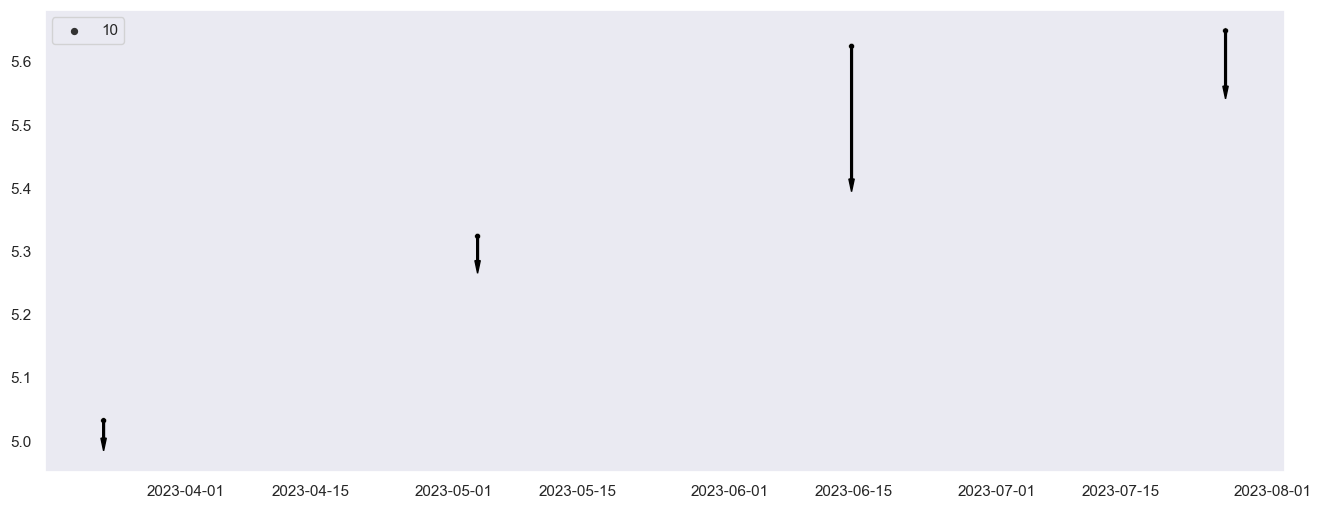

In [29]:
plot_means(before_nfp_release_means, after_nfp_release_means)